Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# [Automated Machine Learning](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-automated-ml)
In this example, we show how automated ML can be used for energy demand forecasting. This notebook is for demonstration purpose only.
<b> Automated ML Feedback : AskAutomatedML@Microsoft.com <b/>

## Contents
1. [How to use Jupyter notebooks](# How to use Jupyter Notebook)
2. [Scenario](#Scenario)
3. [Data](#Data)
4. [Train](#Train)
5. [Deploy](#Deploy)


    
### Note : Pay attention to <font color ="red"> Red Text </font> for "Action Required" in Cells 

# How to use Jupyter Notebook
In this workshop we will be using Jupyter notebooks hosted by Azure Notebooks Service. If you are familiar with Jupyter, skip this. If not, here are a few tips

>* Select the Kernet Python 3.6
>* Jupyter has 'cells'. When you click on anywhere in the notebook, the cell containing the pointer gets selected.
>* To run or execute the code in the cell - on the top menu select Cell->Run Cells. Alternatively you can use 'Shift+Enter' keys.
>* To Edit cell - Double click the cell
>* When you run a cell, the pointer pointing just outside on the left side of the cell will change from [] to [*] (inserts * in the square brackets). When the cell finished executing the '*' changes to a number.
>* If the notebook or cell hangs, select from the top menu Kernel->Restart & Clear output for the entire notebook or Kernel->Interrupt for just that cell. Restart will take a few seconds and you would need to reexecute all the cells.
>* In Jupyter you do not need to execute in sequence. You can go back to a previous cell that was already executed and execute again. As long as there are no dependencies that messes up the code in that particular cell, you will be fine.

# Scenario:

This scenario focuses on energy demand forecasting where the __goal is to predict the future load on an energy grid__. It is a critical business operation for companies in the energy sector as operators need to maintain the fine balance between the energy consumed on a grid and the energy supplied to it. Too much power supplied to the grid can result in waste of energy or technical faults. However, if too little power is supplied it can lead to blackouts, leaving customers without power. Typically, grid operators can take short-term decisions to manage energy supply to the grid and keep the load in balance. An accurate short-term forecast of energy demand is therefore essential for the operator to make these decisions with confidence.

This scenario details the construction of a machine learning energy demand forecasting solution. The solution is trained on a public dataset from the New York Independent System Operator (NYISO), which operates the power grid for New York State. The dataset includes hourly power demand data for New York City over a period of five years. An additional dataset containing hourly weather conditions in New York City over the same time period was taken from darksky.net.

In this notebook you will perform

1. Basic Setup: You would need to create an Azure Machine Learning workspace to start with. You can do that in Azure Portal or through SDK. The workspace can be shared with your team mates to collaborate on the scripts. You would create an workspace one time and run multiple experiments and build many models.

2. Prepare the data: Prepare the data for training.

3. Train an automated ML model: We will use Azure Notebooks to train models with automated ML generated pipeline parameters.

4. Explore the results Inspect various way to get all the models built, Many different model metrics

5. Testing the fitted model with some test data

6. Register the model for deployment and get ready for deployment into Azure Machine Learning model management and deployment hosting

# Basic Setiup
Pre requisites required for configuring your notebook to run Automated ML, setting up your Azure Learning Workspace for the experiment and creating your config.json.

## Install Additional Packages
This is validation step to ensure you have the latest packages to run the exeripment

In [1]:
# auto ml core packages update
!pip install --upgrade azureml-sdk[automl]

Requirement already up-to-date: azureml-sdk[automl] in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (1.0.17)


In [2]:
# auto ml core packages update
!pip install --upgrade azureml-sdk[notebooks]

Requirement already up-to-date: azureml-sdk[notebooks] in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (1.0.17)


In [64]:
# auto ml core packages update
!pip install --upgrade azureml-sdk[explain]

Requirement already up-to-date: azureml-sdk[explain] in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (1.0.17)


  Found existing installation: azureml-explain-model 1.0.15


    Uninstalling azureml-explain-model-1.0.15:
      Successfully uninstalled azureml-explain-model-1.0.15


In [3]:
# Webservice schema for Swagger compatibility. Install will take a few minutes
!pip install --upgrade azureml-sdk[webservice-schema]

Requirement already up-to-date: azureml-sdk[webservice-schema] in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (1.0.17)
  Using cached https://files.pythonhosted.org/packages/f8/9a/b456d118ddc0c3a399ec0ea49afe9b37ff240fab003ef956c2e83ed610cd/azureml_webservice_schema-1.0.17-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ee/2f/709df6e8dc00624689aa0a11c7a4c06061a7d00037e370584b9f011df44c/pyspark-2.3.1.tar.gz


  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='pypi.org', port=443): Read timed out. (read timeout=15)",)': /simple/py4j/
  Using cached https://files.pythonhosted.org/packages/e3/53/c737818eb9a7dc32a7cd4f1396e787bd94200c3997c72c1dbe028587bd76/py4j-0.10.7-py2.py3-none-any.whl
  Stored in directory: /home/nbuser/.cache/pip/wheels/37/48/54/f1b63f0dbb729e20c92f1bbcf1c53c03b300e0b93ca1781526
Successfully built pyspark


In [1]:
import azureml.core

print("This notebook was created using version 1.0.17 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.0.17 of the Azure ML SDK
You are currently using version 1.0.17 of the Azure ML SDK


## Configure your Azure ML workspace

### Workspace parameters

To use an AML Workspace, you will need to import the Azure ML SDK and supply the following information:
* Your subscription id
* A resource group name
* (optional) The region that will host your workspace
* A name for your workspace

You can get your subscription ID from the [Azure portal](https://portal.azure.com).

You will also need access to a [_resource group_](https://docs.microsoft.com/en-us/azure/azure-resource-manager/resource-group-overview#resource-groups), which organizes Azure resources and provides a default region for the resources in a group.  You can see what resource groups to which you have access, or create a new one in the [Azure portal](https://portal.azure.com).  If you don't have a resource group, the create workspace command will create one for you using the name you provide.

The region to host your workspace will be used if you are creating a new workspace.  You do not need to specify this if you are using an existing workspace. You can find the list of supported regions [here](https://azure.microsoft.com/en-us/global-infrastructure/services/?products=machine-learning-service).  You should pick a region that is close to your location or that contains your data.

The name for your workspace is unique within the subscription and should be descriptive enough to discern among other AML Workspaces.  The subscription may be used only by you, or it may be used by your department or your entire enterprise, so choose a name that makes sense for your situation.

The following cell allows you to specify your workspace parameters.  This cell uses the python method `os.getenv` to read values from environment variables which is useful for automation.  If no environment variable exists, the parameters will be set to the specified default values.  

If you ran the Azure Machine Learning [quickstart](https://docs.microsoft.com/en-us/azure/machine-learning/service/quickstart-get-started) in Azure Notebooks, you already have a configured workspace!  You can go to your Azure Machine Learning Getting Started library, view *config.json* file, and copy-paste the values for subscription ID, resource group and workspace name below.

Replace the default values in the cell below with your workspace parameters

In [ ]:
import os

subscription_id = os.getenv("SUBSCRIPTION_ID", default="<my-subscription-id>")
print(subscription_id)
resource_group = os.getenv("RESOURCE_GROUP", default="my-automl-workshop-rg")
print(resource_group)
workspace_name = os.getenv("WORKSPACE_NAME", default="my-automl-workshop-ws")
print(workspace_name)
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")
print(workspace_region)

### Access your workspace

The following cell uses the Azure ML SDK to attempt to load the workspace specified by your parameters.  If this cell succeeds, your notebook library will be configured to access the workspace from all notebooks using the `Workspace.from_config()` method.  The cell can fail if the specified workspace doesn't exist or you don't have permissions to access it. 

In [6]:
from azureml.core import Workspace

try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config()
    print("Workspace configuration succeeded. Skip the workspace creation steps below")
except:
    print("Workspace not accessible. Change your parameters or create a new workspace below")

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FFR89MEMB to authenticate.
Interactive authentication successfully completed.
Wrote the config file config.json to: /home/nbuser/library/aml_config/config.json
Workspace configuration succeeded. Skip the workspace creation steps below


### Create a new workspace

If you don't have an existing workspace and are the owner of the subscription or resource group, you can create a new workspace.  If you don't have a resource group, the create workspace command will create one for you using the name you provide.

**Note**: As with other Azure services, there are limits on certain resources (for example AmlCompute quota) associated with the Azure ML service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

This cell will create an Azure ML workspace for you in a subscription provided you have the correct permissions.

This will fail if:
* You do not have permission to create a workspace in the resource group
* You do not have permission to create a resource group if it's non-existing.
* You are not a subscription owner or contributor and no Azure ML workspaces have ever been created in this subscription

If workspace creation fails, please work with your IT admin to provide you with the appropriate permissions or to provision the required resources.

In [7]:
from azureml.core import Workspace

# Create the workspace using the specified parameters
ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,
                      create_resource_group = True,
                      exist_ok = True)
ws.get_details()

# write the details of the workspace to a configuration file to the notebook library
ws.write_config()

Wrote the config file config.json to: /home/nbuser/library/aml_config/config.json


# Experiment Setup
Import packages required for the experiment

In [8]:
# Import libraries
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings
# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None


from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Verify the config file
We read the config.json file and verify the experiment workspace, subscription etc. are defined correctly.

In [9]:
# Retrieve workspace
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'automl-energydemandforecasting'
# project folder
project_folder = './sample_projects/automl-local-energydemandforecasting'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

Found the config file in: /home/nbuser/library/aml_config/config.json


,
Location,eastus2
Project Directory,./sample_projects/automl-local-energydemandforecasting
Resource Group,myrg_nilesha2
Run History Name,automl-energydemandforecasting
SDK version,1.0.17
Subscription ID,381b38e9-9840-4719-a5a0-61d9585e1e91
Workspace,myws_nilesha2


# Data
Read energy demanding data from file, and preview data.

In [18]:
data = pd.read_csv("nyc_energy.csv", parse_dates=['timeStamp'])
data.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.50,0.00,46.13
1,2012-01-01 01:00:00,4752.10,0.00,45.89
2,2012-01-01 02:00:00,4542.60,0.00,45.04
3,2012-01-01 03:00:00,4357.70,0.00,45.03
4,2012-01-01 04:00:00,4275.50,0.00,42.61


,count,mean,std,min,25%,50%,75%,max
demand,49124.00,6067.45,1285.61,2859.60,5133.86,6020.07,6684.30,11456.00
precip,48975.00,0.00,0.02,0.00,0.00,0.00,0.00,0.91
temp,49019.00,55.52,17.70,0.33,41.41,56.26,70.54,97.26


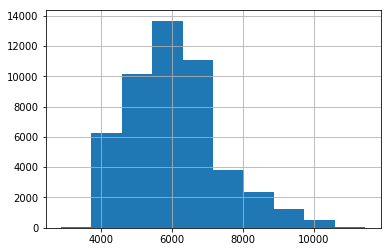

In [23]:
display(data.describe().T)
data.demand.hist()

## Split the data
We are setting aside data that is newer than Feb 1st 2017 as test data set. All the data that is older that Feb 1st 2017 is the training data.

In [28]:
train = data[data['timeStamp'] < '2017-02-01']
test = data[data['timeStamp'] >= '2017-02-01']

## Prepare the test data, we will feed X_test to the fitted model and get prediction

In [29]:
y_test = test.pop('demand').values
X_test = test

## Split the train data to train and valid
Use one month's data as valid data

In [30]:
X_train = train[train['timeStamp'] < '2017-01-01']
X_valid = train[train['timeStamp'] >= '2017-01-01']
y_train = X_train.pop('demand').values
y_valid = X_valid.pop('demand').values
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(43847, 3)
(43847,)
(744, 3)
(744,)


# Train Using Automated ML
You will configure automated ML and run automated ML experiment which will generate Machine Learning Models. The training jobs are run on VMs provided and managed by Azure Notebooks. 
There are many configuration parameters you can define for your experiment. . Read more in the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train)

## Configure Automated ML Experiment

In [31]:
# Set the time series column
time_column_name = 'timeStamp'
automl_settings = {
    "time_column_name": time_column_name,
}

# create the configuration object
automl_config = AutoMLConfig(task = 'forecasting',
                             debug_log = 'automl_nyc_energy_errors.log',
                             primary_metric='normalized_root_mean_squared_error',
                             iterations = 5,
                             iteration_timeout_minutes = 10,
                             X = X_train,
                             y = y_train,
                             X_valid = X_valid,
                             y_valid = y_valid,
                             path=project_folder,               
                             blacklist_models = ['RandomForest'],
                             verbosity = logging.INFO,
                            **automl_settings)

You can call the submit method on the experiment object and pass the run configuration. For Local runs the execution is synchronous. Depending on the data and number of iterations this can run for while.
You will see the currently running iterations printing to the console.

In [32]:
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_2d8299a8-fca9-4923-9ed4-a565372f2b8c
********************************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
SAMPLING %: Percent of the training data to sample.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
********************************************************************************************************************

 ITERATION   PIPELINE                                       SAMPLING %  DURATION      METRIC      BEST
         0   StandardScalerWrapper ElasticNet               100.0000    0:00:41       0.0811    0.0811
         1   TruncatedSVDWrapper ElasticNet                 100.0000    0:00:40       0.0823    0.0811
         2   RobustScaler ElasticNet                        100

In [33]:
# View the run summary
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-energydemandforecasting,AutoML_2d8299a8-fca9-4923-9ed4-a565372f2b8c,automl,Completed,Link to Azure Portal,Link to Documentation


## Widget for monitoring runs

In [34]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Retrieve All Child Runs

In [35]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4
explained_variance,0.25,0.23,0.27,0.22,0.26
mean_absolute_error,554.94,561.75,561.89,567.33,555.04
median_absolute_error,436.69,456.13,457.65,473.89,438.96
normalized_mean_absolute_error,0.06,0.07,0.07,0.07,0.06
normalized_median_absolute_error,0.05,0.05,0.05,0.06,0.05
normalized_root_mean_squared_error,0.08,0.08,0.08,0.08,0.08
normalized_root_mean_squared_log_error,0.09,0.09,0.09,0.09,0.09
r2_score,0.25,0.22,0.24,0.21,0.25
root_mean_squared_error,697.49,707.54,700.83,713.22,695.70
root_mean_squared_log_error,0.12,0.12,0.12,0.13,0.12


## Retrieve the Best Model
Below we select the best pipeline from our iterations. The get_output method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing. Overloads on get_output allow you to retrieve the best run and fitted model for any logged metric or for a particular iteration.

In [36]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: automl-energydemandforecasting,
Id: AutoML_2d8299a8-fca9-4923-9ed4-a565372f2b8c_4,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('timeseriestransformer', TimeSeriesTransformer(logger=None)), ('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('ElasticNet', Pipeline(memory=None,
     steps=[('standardscalerwrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7fb4a...ol=0.0001, warm_start=False))]))],
               flatten_transform=None, weights=[0.2, 0.2, 0.4]))])


## Best Model Based on Any Other Metric
Show the run and the model that has the smallest log_loss value

In [57]:
lookup_metric = "r2_score"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print(best_run)
print(fitted_model)

Run(Experiment: automl-energydemandforecasting,
Id: AutoML_2d8299a8-fca9-4923-9ed4-a565372f2b8c_7,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('timeseriestransformer', TimeSeriesTransformer(logger=None)), ('standardscalerwrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7fb4a2a6f588>), ('lightgbmregressor', <automl.client.core.common.model_wrappers.LightGBMRegressor object at 0x7fb4a2a6fc18>)])


# Model from a Specific Iteration
Show the run and the model from the third iteration:

In [38]:
iteration = 3
third_run, third_model = local_run.get_output(iteration = iteration)
print(third_run)
print(third_model)

Run(Experiment: automl-energydemandforecasting,
Id: AutoML_2d8299a8-fca9-4923-9ed4-a565372f2b8c_3,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('timeseriestransformer', TimeSeriesTransformer(logger=None)), ('standardscalerwrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7fb4a4d5ebe0>), ('elasticnet', ElasticNet(alpha=0.8422631578947368, copy_X=True, fit_intercept=True,
      l1_ratio=0.21842105263157896, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False))])


## Continue experiment for more iterations (Optional)
If you want you can continue to run more iterations,picking up where you left off. 

In [41]:
# continue training for another couple of iterations
local_run.continue_experiment(X=X_train, y=y_train,X_valid = X_valid,y_valid = y_valid,iterations = 2)
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Retrieve explanation for best model
Model explainability is important to understand the features and their importance. This will retrieve the explainability of the model.

In [2]:
# Commented out, please run after Workshop as takes some time

#from azureml.train.automl.automlexplainer import explain_model
#shap_values, expected_values, overall_summary, overall_imp, per_class_summary, per_class_imp = \
#   explain_model(fitted_model, X_train, X_test, best_run)

# Test the Best Fitted Model
Predict on training and test set, and calculate residual values.

In [42]:
y_pred = fitted_model.predict(X_test)
y_pred

array([4906.67348594, 5009.79521691, 5104.69914098, ..., 6111.8636322 ,
       6136.57378885, 6163.53755292])

# Use the Check Data Function to remove the nan values from y_test to avoid error when calculate metrics

In [43]:
if len(y_test) != len(y_pred):
    raise ValueError(
        'the true values and prediction values do not have equal length.')
elif len(y_test) == 0:
    raise ValueError(
        'y_true and y_pred are empty.')

# if there is any non-numeric element in the y_true or y_pred,
# the ValueError exception will be thrown.
y_test_f = np.array(y_test).astype(float)
y_pred_f = np.array(y_pred).astype(float)

# remove entries both in y_true and y_pred where at least
# one element in y_true or y_pred is missing
y_test = y_test_f[~(np.isnan(y_test_f) | np.isnan(y_pred_f))]
y_pred = y_pred_f[~(np.isnan(y_test_f) | np.isnan(y_pred_f))]

# Plot the predictions to compare to actual data

[Test Data] 
Root Mean squared error: 885.01
mean_absolute_error score: 718.49
R2 score: 0.53


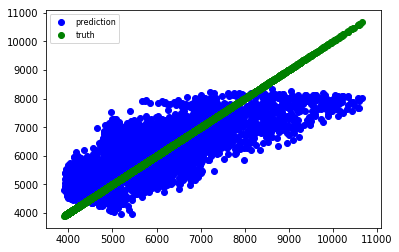

In [44]:
print("[Test Data] \nRoot Mean squared error: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
# Explained variance score: 1 is perfect prediction
print('mean_absolute_error score: %.2f' % mean_absolute_error(y_test, y_pred))
print('R2 score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
test_pred = plt.scatter(y_test, y_pred, color='b')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

# Deploy
Deploy the model into an Azure Container Instance to enable inferencing on new data

## Register the model
Register the best model to the AML service

In [45]:
model = local_run.register_model(description = 'automated ml model for energy demand forecasting', tags = {'ml': "Forecasting", 'type': "automl"})
print(local_run.model_id) # This will be written to the script file later in the notebook.

Registering model AutoML2d8299a8fbest
AutoML2d8299a8fbest


## Create Scoring Script
This will be used to run the model on new data for predictions

In [46]:
%%writefile score_energy_demand.py
import pickle
import json
import numpy as np
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model


def init():
    global model
    model_path = Model.get_model_path(model_name = '<<modelid>>') # this name is model.id of model that we want to deploy
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

def run(timestamp,precip,temp):
    try:
        rawdata = json.dumps({timestamp, precip, temp})
        data = json.loads(rawdata)
        data_arr = numpy.array(data)
        result = model.predict(data_arr)
        # result = json.dumps({'timeStamp':timestamp, 'precip':precip, 'temp':temp})
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})
    return json.dumps({"result":result.tolist()})

Overwriting score_energy_demand.py


## Create a YAML File for the Environment¶ 
The YAML file will be used to setup the conda environment on the deployed image

In [47]:
# Retrieve the dependencies
experiment = Experiment(ws, experiment_name)
ml_run = AutoMLRun(experiment = experiment, run_id = local_run.id)
dependencies = ml_run.get_run_sdk_dependencies(iteration = 0)
for p in ['azureml-train-automl', 'azureml-sdk', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

No issues found in the SDK package versions.
azureml-train-automl	1.0.17.1
azureml-sdk	1.0.17
azureml-core	1.0.17.1


In [48]:
# Create the environment file

from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'], pip_packages=["azureml-train-automl"])
print(myenv.serialize_to_string())

conda_env_file_name = 'my_conda_env.yml'
myenv.save_to_file('.', conda_env_file_name)

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-train-automl==1.0.17
- numpy
- scikit-learn



'my_conda_env.yml'

In [49]:
# Substitute the actual version number in the environment file.
# This is not strictly needed in this notebook because the model should have been generated using the current SDK version.
# However, we include this in case this code is used on an experiment from a previous SDK version.

with open(conda_env_file_name, 'r') as cefr:
    content = cefr.read()

with open(conda_env_file_name, 'w') as cefw:
    cefw.write(content.replace(azureml.core.VERSION, dependencies['azureml-sdk']))

# Substitute the actual model id in the script file.

script_file_name = 'score_energy_demand.py'

with open(script_file_name, 'r') as cefr:
    content = cefr.read()

with open(script_file_name, 'w') as cefw:
    cefw.write(content.replace('<<modelid>>', local_run.model_id))

## Generate schema file
Schema file is used to define the deployed web service REST API, so it is consumable from "Swagger enabled" services, such as Power BI

In [50]:
from azureml.webservice_schema.sample_definition import SampleDefinition
from azureml.webservice_schema.data_types import DataTypes
from azureml.webservice_schema.schema_generation import generate_schema

schema_file_name = './schema.json'
def run(timestamp,precip,temp):
    return "OK"

import numpy as np
generate_schema(run, inputs={
    "timestamp" : SampleDefinition(DataTypes.STANDARD, '2012-01-01 00:00:00'),
    "precip" : SampleDefinition(DataTypes.STANDARD, '0.0'),
    "temp" : SampleDefinition(DataTypes.STANDARD, '0.0')}, 
    filepath=schema_file_name)

{'input': {'timestamp': {'internal': 'gANjYXp1cmVtbC53ZWJzZXJ2aWNlX3NjaGVtYS5fcHl0aG9uX3V0aWwKUHl0aG9uU2NoZW1hCnEAKYFxAX1xAlgJAAAAZGF0YV90eXBlcQNjYnVpbHRpbnMKc3RyCnEEc2Iu',
   'swagger': {'type': 'string', 'example': '2012-01-01 00:00:00'},
   'type': 0,
   'version': '1.0.17'},
  'precip': {'internal': 'gANjYXp1cmVtbC53ZWJzZXJ2aWNlX3NjaGVtYS5fcHl0aG9uX3V0aWwKUHl0aG9uU2NoZW1hCnEAKYFxAX1xAlgJAAAAZGF0YV90eXBlcQNjYnVpbHRpbnMKc3RyCnEEc2Iu',
   'swagger': {'type': 'string', 'example': '0.0'},
   'type': 0,
   'version': '1.0.17'},
  'temp': {'internal': 'gANjYXp1cmVtbC53ZWJzZXJ2aWNlX3NjaGVtYS5fcHl0aG9uX3V0aWwKUHl0aG9uU2NoZW1hCnEAKYFxAX1xAlgJAAAAZGF0YV90eXBlcQNjYnVpbHRpbnMKc3RyCnEEc2Iu',
   'swagger': {'type': 'string', 'example': '0.0'},
   'type': 0,
   'version': '1.0.17'}}}

## Create a Docker file to include extra dependencies in the image
The container image will be based on the model and is used to deploy the container instance

In [51]:
%%writefile docker_steps.dockerfile
RUN apt-get update && \
    apt-get upgrade -y && \
    apt-get install -y build-essential gcc g++ python-dev unixodbc unixodbc-dev

Overwriting docker_steps.dockerfile


In [52]:
docker_file_name = "docker_steps.dockerfile"

## Create a Container Image
The container image will be based on the model and is used to deploy the container instance

In [52]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script = script_file_name,
                                 docker_file = docker_file_name,
                                 schema_file = schema_file_name,
                                 conda_file = conda_env_file_name,
                                 tags = {'ml': "Forecasting", 'type': "automl"},
                                 description = "Image for automated ml energy demand forecasting predictions")

image = Image.create(name = "automlenergyforecasting",
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

Creating image
Running.............................................................................
SucceededImage creation operation finished for image automlenergyforecasting:4, operation "Succeeded"


## Deploy the Image as a Web Service on Azure Container Instance

In [54]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'ml': "Forecasting", 'type': "automl"}, 
                                               description = 'ACI service for automated ml energy demand forecasting predictions')

In [61]:
from azureml.core.webservice import Webservice

aci_service_name = 'automlenergyforecasting1'
print(aci_service_name)
aci_service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automlenergyforecasting1
Creating service
Running.................................................
FailedACI service creation operation finished, operation "Failed"
Service creation polling reached terminal state, current service state: Failed
{
  "code": "AciDeploymentFailed",
  "message": "Aci Deployment failed with exception: Your container application crashed. This may be caused by errors in your scoring file's init() function.\nPlease check the logs for your container instance automlenergyforecasting1.\nYou can also try to run image mywsnileacrrgpoupjx.azurecr.io/automlenergyforecasting:4 locally. Please refer to http://aka.ms/debugimage for more information.",
  "details": [
    {
      "code": "AciDeploymentFailed",
      "message": "Aci Deployment failed with exception: {\"code\":\"AciDeploymentFailed\",\"message\":\"Aci Deployment failed with exception: Your container application crashed. This may be caused by errors in your scoring file's init() function.\\nPlease check the l

# Recap

In this workshop we have successfully
* Imported a CSV file for training 
* Split the data for test and validation
* Configured an automated ML experiment
* Run an automated ML experiment
* Reviewed the results
* Taken the best best model and plotted predications
* Deployed a model as a web service ready to make new inferences

# Resources
Automated ML & Azure Machine Learning Resources

* AskAutomatedML@microsoft.com
* https://aka.ms/AutomatedML
* https://aka.ms/AutomatedMLDocs
* https://github.com/Azure/MachineLearningNotebooks